In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
class Dense_layer(nn.Module):#こっち一塊
    def __init__(self,in_channels,grouth_rate,drop_rate):
        super().__init__()
        self.bn1=nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1= nn.Conv2d(in_channels,out_channels=4*grouth_rate,kernel_size=1,)#grouth_rateがoutput_channels channel数を増やしているのか減らしているのか.....
        self.bn2=nn.BatchNorm2d(num_features= grouth_rate*4)
        self.relu= nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(in_channels=grouth_rate*4,out_channels=grouth_rate,kernel_size=3,padding=1)#このpaddingは出力する特徴マップのサイズを落とさないようにするため、出力サイズが変わると連結ができない
        self.dropout = nn.Dropout(p=drop_rate)
    def forward(self, x):
        #print("input",x.shape)
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        #print(f'After conv1: {out.shape}')  # 形状を確認
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        #print(f'After conv2: {out.shape}')  # 形状を確認
        out = self.dropout(out)
        out = torch.cat([x, out], 1)  # チャネル方向で入力xと出力outを結合
        #print(f'After cat: {out.shape}')  # 形状を確認
        return out

In [4]:
class transitiion_layer(nn.Module): #入力チャネル=m個　→　出力チャネル=mΘ 0<=θ<=1 改良ポイント
    def __init__(self,in_channels,parameter=1):
        super().__init__()
        self.bn1=nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=parameter*in_channels,kernel_size=1)
        self.pool1 = nn.AvgPool2d(kernel_size = 2,stride=2)
    def forward(self,x):
        #print("transitiion_layer",x.shape)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.pool1(x)
        return x

In [5]:
class DenseNet(nn.Module):
    def __init__(self,in_channels,grouth_rate,layer_num,drop_rate=0,num_classes=1000):#layer numを配列にしましょう
        super().__init__()
        
        #-----------------初めのレイヤーたち
        self.first = nn.Sequential()
        self.first.add_module(
            "conv0",nn.Conv2d(in_channels,out_channels=16,kernel_size=7,stride=2,padding=3)
        )
        self.first.add_module("BN0",nn.BatchNorm2d(num_features=16))
        self.first.add_module("relu0",nn.ReLU(inplace=True))
        self.first.add_module("maxpool0",nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        #---------------------------------------------------------
        channel1 = 16+layer_num[0]*grouth_rate
        channel2 = channel1+layer_num[1]*grouth_rate
        channel3 = channel2+layer_num[2]*grouth_rate
        channel4 = channel3+layer_num[3]*grouth_rate
        parameter=1
        self.dense_block1 = self._make_Dense_block(in_channels=16,grouth_rate=grouth_rate,layer_num=layer_num[0],drop_rate=drop_rate)
        self.transition1 = transitiion_layer(in_channels=channel1,parameter=parameter)
        self.dense_block2 = self._make_Dense_block(in_channels=channel1,grouth_rate=grouth_rate,layer_num=layer_num[1],drop_rate=drop_rate)
        self.transition2 = transitiion_layer(in_channels=channel2,parameter=1)
        self.dense_block3 = self._make_Dense_block(in_channels=channel2,grouth_rate=grouth_rate,layer_num=layer_num[2],drop_rate=drop_rate)
        self.transition3 = transitiion_layer(in_channels=channel3,parameter=parameter)
        self.dense_block4 = self._make_Dense_block(in_channels=channel3,grouth_rate=grouth_rate,layer_num=layer_num[3],drop_rate=drop_rate,)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=channel4,out_features=num_classes)
        return
    def forward(self,x):
        x = self.first(x)
        x = self.dense_block1(x)
        x = self.transition1(x)
        x = self.dense_block2(x)
        x = self.transition2(x)
        x = self.dense_block3(x)
        x = self.transition3(x)
        x = self.dense_block4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    def _make_Dense_block(self, in_channels,grouth_rate,layer_num,drop_rate):#こっちにdenseLayerを複数入れる
        layers = []
        next_in_channels = in_channels
        """print("----layer_num-----",layer_num,)
        print("----growth_rate----",grouth_rate)"""
        for i in range(layer_num):
            #print("in_channels=",next_in_channels)
            #print("__i__=",i)
            layers.append(Dense_layer(in_channels=next_in_channels,grouth_rate=grouth_rate,drop_rate=drop_rate))
            #print("out_channel=",in_channels + grouth_rate*i)
            next_in_channels += grouth_rate
            #print("next_in=",next_in_channels)
        return nn.Sequential(*layers)
    
    



In [6]:
def densenet121():
    return DenseNet(in_channels=3,grouth_rate=32, layer_num=[6, 12, 24, 16])
  

In [7]:
from torchinfo import summary
model = densenet121()
batch_size=128
model
summary(model,
        input_size=(batch_size,3,32,32)
        )

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [128, 1000]               --
├─Sequential: 1-1                        [128, 16, 8, 8]           --
│    └─Conv2d: 2-1                       [128, 16, 16, 16]         2,368
│    └─BatchNorm2d: 2-2                  [128, 16, 16, 16]         32
│    └─ReLU: 2-3                         [128, 16, 16, 16]         --
│    └─MaxPool2d: 2-4                    [128, 16, 8, 8]           --
├─Sequential: 1-2                        [128, 208, 8, 8]          --
│    └─Dense_layer: 2-5                  [128, 48, 8, 8]           --
│    │    └─BatchNorm2d: 3-1             [128, 16, 8, 8]           32
│    │    └─ReLU: 3-2                    [128, 16, 8, 8]           --
│    │    └─Conv2d: 3-3                  [128, 128, 8, 8]          2,176
│    │    └─BatchNorm2d: 3-4             [128, 128, 8, 8]          256
│    │    └─ReLU: 3-5                    [128, 128, 8, 8]          --
│    │  

After conv1: torch.Size([128, 20, 62, 62]) バッチサイズ　チャネル数　高さ　幅
After conv2: torch.Size([128, 5, 62, 62])
After cat: torch.Size([128, 21, 62, 62])

In [8]:
train_data = datasets.CIFAR10('./../ResNet/data', #データを保存するdir
                              train = True,  #True : 学習用データ False : テストデータ 
                              download=True,  # downloadするか否か
                              transform = transforms.Compose([transforms.ToTensor()]) #前処理の設定
                              )
train_loader = DataLoader(train_data,batch_size=64)
#32*32の3チャネル画像

Files already downloaded and verified


In [9]:
def load_cifar10(batch=256):
    train_loader = DataLoader(
        datasets.CIFAR10('./../ResNet/data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    return {'train': train_loader, 'test': test_loader}

Files already downloaded and verified
Files already downloaded and verified
cuda:0
Training log: 1 epoch (128 / 50000 train. data). Loss: 6.919581413269043
Training log: 1 epoch (1408 / 50000 train. data). Loss: 6.404002666473389
Training log: 1 epoch (2688 / 50000 train. data). Loss: 5.360477924346924
Training log: 1 epoch (3968 / 50000 train. data). Loss: 3.8070995807647705
Training log: 1 epoch (5248 / 50000 train. data). Loss: 2.4861624240875244
Training log: 1 epoch (6528 / 50000 train. data). Loss: 2.156111717224121
Training log: 1 epoch (7808 / 50000 train. data). Loss: 2.0307846069335938
Training log: 1 epoch (9088 / 50000 train. data). Loss: 1.9331976175308228
Training log: 1 epoch (10368 / 50000 train. data). Loss: 1.9351329803466797
Training log: 1 epoch (11648 / 50000 train. data). Loss: 1.8399550914764404
Training log: 1 epoch (12928 / 50000 train. data). Loss: 1.780522346496582
Training log: 1 epoch (14208 / 50000 train. data). Loss: 1.7460846900939941
Training log: 1 epo

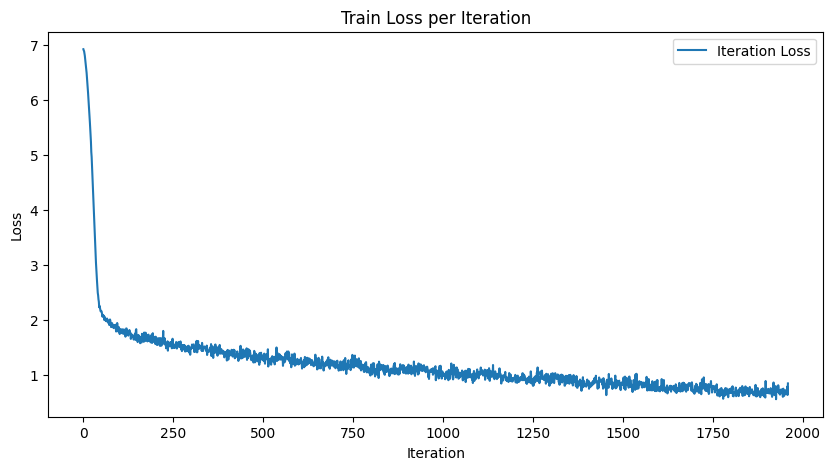

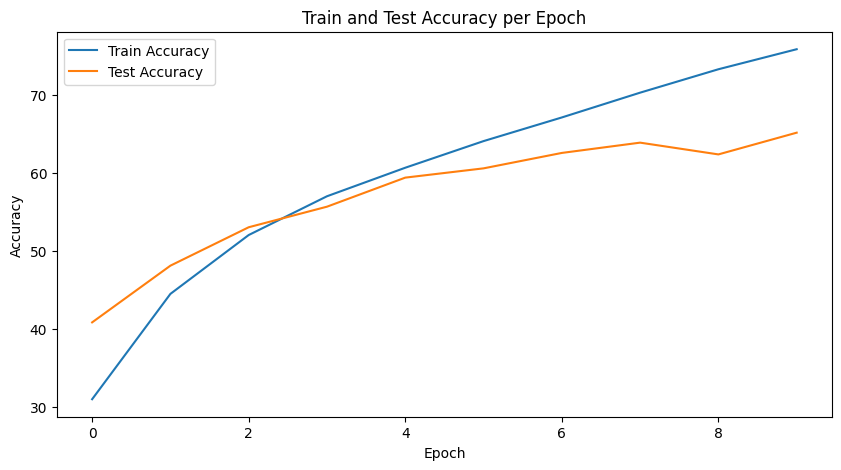

In [10]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['iter_loss'], label='Iteration Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss per Iteration')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy per Epoch')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    epoch = 10
    
    loader = load_cifar10()
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    net = densenet121()
    criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)  # lr=学習率,

    # 学習前のフィルタの可視化
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    print(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'iter_loss': [],
    }

    for e in range(epoch):
        net.train()
        loss = None
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device)  # to GPU?
            labels = labels.to(device)
            optimizer.zero_grad()  # パラメータの初期化
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()  # lossを逆伝搬
            optimizer.step()
            history['iter_loss'].append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 10 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e + 1,
                                                                                         (i + 1) * 128,
                                                                                         loss.item())
                      )

        train_acc = 100 * correct / total
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)
        
        # Test Phase
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader['test']:
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100 * correct / total
        history['test_acc'].append(test_acc)

        print('Epoch {} - Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Acc: {:.2f}%'.format(
            e + 1, loss.item(), train_acc, test_acc))
    
    # Plotting the results
    plot_loss(history)
    plot_accuracy(history)


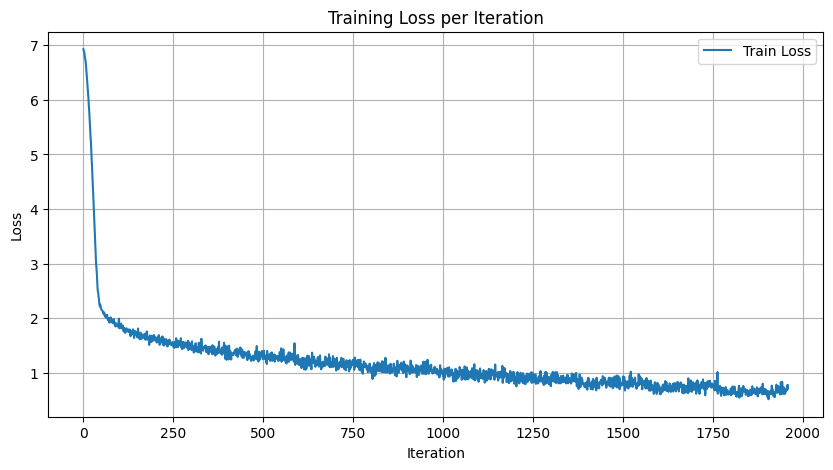

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history["iter_loss"], label='Train Loss')
plt.title('Training Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 40/40 [00:01<00:00, 21.10it/s]


ValueError: x and y must have same first dimension, but have shapes (10,) and (2,)

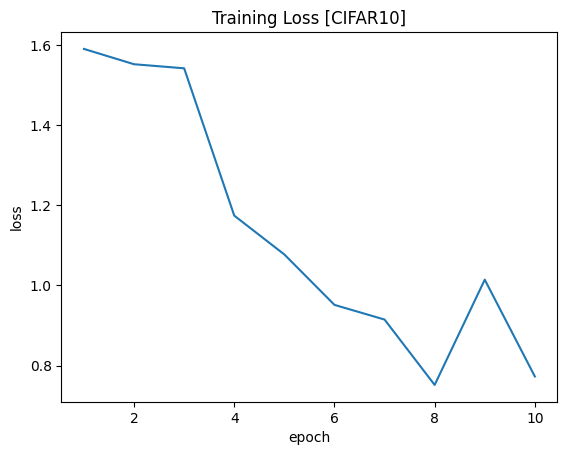

In [16]:
from tqdm import tqdm
import matplotlib.pyplot as plt
net.eval()
correct = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(tqdm(loader['train'])):
        images = images.to(device)  # to GPU?
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

acc = float(correct / 50000)
history['train_acc'].append(acc)

correct = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(tqdm(loader['test'])):
        images = images.to(device)  # to GPU?
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

acc = float(correct / 10000)
history['test_acc'].append(acc)

# 結果をプロット
plt.plot(range(1, epoch+1), history['train_loss'])
plt.title('Training Loss [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig('img/cifar10_loss.png')
#plt.close()

plt.plot(range(1, epoch ), history['train_acc'], label='train_acc')
plt.plot(range(1, epoch ), history['test_acc'], label='test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('img/cifar10_acc.png')
plt.close()

ValueError: x and y must have same first dimension, but have shapes (9,) and (2,)

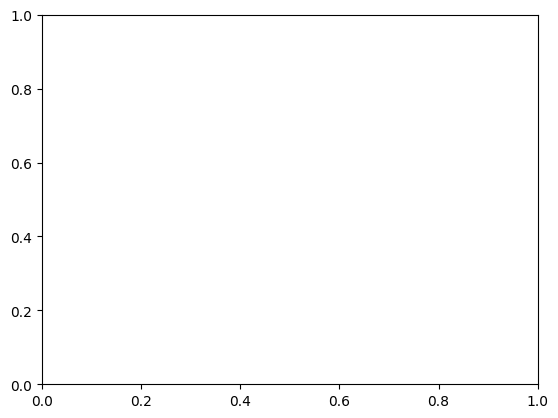

In [17]:
plt.plot(range(1, epoch ), history['train_acc'], label='train_acc')
plt.plot(range(1, epoch ), history['test_acc'], label='test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('img/cifar10_acc.png')
plt.close()